# IS 597 MLC Final Project

## Corinne McCumber

Notebook Outline:
1. Setup
    - Libraries and storage
    - Data set
    - Research questions
2. Loading Data
3. Descriptive Data Analysis and Visualization: Raw Data before Preprocessing
    - Wordclouds
    - Number of characters analysis
    - Word count analysis
    - Average word length analysis
4. Create Derived Features: Word Count and URL Presence
5. Data Preprocessing
    - Stemming
    - Lemmatization
6. Removing Instances Where Preprocessing Removed All Text
7. Splitting Data
8. Data visualization using X_train_stem data
    - Wordclouds
    - Number of characters analysis
    - Word count analysis
    - Average word length analysis
9. Vectorization
    - TF-IDF
    - Word2Vec
10. Research Questions 1 & 2: Model Training and Comparison
    - SVM with stemming and TFIDF
    - SVM with stemming and Word2Vec
    - SVM with lemmatization and TFIDF
    - SVM with lemmatization and Word2Vec
    - RF with stemming and TFIDF
    - RF with stemming and Word2Vec
    - RF with lemmatization and TFIDF
    - RF with lemmatization and Word2Vec
11. Research Questions 1 & 2: Model Finetuning for Selected Models
    - SVM with stemming and TFIDF
    - RF with lemmatization and TFIDF
12. Research Question 3: Using Derived Features
    - Adding derived features to Word2Vec training data
13. Research Question 3: Training Word2Vec models with derived features
    - SVM with lemmatization and Word2Vec+
    - RF with lemmatization and Word2Vec+
14. Aggregate Model Comparison

## 1. Setup

### Libraries and storage

**IMPORTANT**: The notebook instance I am using is ml.r5.xlarge, with the volume size set to 100GB EBS. This is primarily to accommodate the pretrained Word2Vec model, which is 1662 MB on its own. Sometimes the Word2Vec model causes memory issues when being loaded in.

In [1]:
# Install Word2Vec package and wordcloud, only needed if this is the first run-through of the notebook.
!pip install --upgrade gensim
!pip install --upgrade wordcloud

  Using cached gensim-4.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.2 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
Using cached gensim-4.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
  Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import gensim.downloader as gensim_api

from wordcloud import WordCloud

import multiprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from final_project_modules import *

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
#### Check memory usage
#!free -h

#### Clear occupied memory
#import gc
#gc.collect()

#### Check memory usage again
#!free -h

### Data set

The dataset I utilize is the Super Dataset created by Salman et al. (2024), which is available at https://github.com/smspamresearch/spstudy as a 6.57 MB .csv file. This dataset was created by combining 6 existing public SMS spam datasets and expanding with data collected from Twitter (now X), scam observatory websites, and volunteers. Salman et al. then removed duplicate and non-English messages from the dataset, and three researchers individually labeled all non-labeled messages as spam or legitimate. The resulting Super Dataset reportedly contains 67,018 instances, with 40,837 legitimate and 26,181 spam SMS messages spanning from 2012-2023. Of note, when the dataset was downloaded on June 26, 2024, only 67,009 instances were available; 40,830 (60.9%) instances were labeled as legitimate, 26,178 (39.1%) were labeled as spam, 1 label was missing, and one row was blank. Each message instance has two attributes: (a) the entire text of the SMS message as a string and (b) the label of 0 (legitimate) or 1 (spam), in the columns “SMSes” and “Labels” respectively. The target class for my project is, perhaps obviously, the label of 0 (legitimate) or 1 (spam).

### Research questions
1. Using a larger, balanced, up-to-date dataset, can SVM and RF still achieve 99%+ accuracy in classifying SMS spam based on the text of a SMS message, similar to that described by Uddin et al. (2024)^ and Abid et al. (2022)^? 
2. Between TF-IDF and Word2Vec, which feature extraction method provides the best basis for each model?
3. Does including features related to message length and presence of a URL improve model accuracy?

OF NOTE: Due to memory size limitations, Questions 1 & 2 and Question 3 had to be investigated somewhat separately.

^ see full project write-up for details

## 2. Loading Data

In [4]:
X, y = load_data('super_sms_dataset.csv')

********** Loading data **********

No of Rows: 67010
No of Columns: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67010 entries, 0 to 67009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    67009 non-null  object 
 1   label   67008 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB
None

No of rows (After dropping null): 67008
No of columns: 2

No of rows (After removing duplicates): 66986
No of columns: 2

Data View: First Few Instances
                                                                                                  text  \
0        There be an update for your delivery CC 01728161E due 09.06.2020 Tap here http://olo.me/3i6xF   
1  watch your favorite english movies of all genre like fast  furious  the thaw stepup  in just rs ...   
2                                                                       aur what is the status for fms   
3  hi shalini sundi tha

## 3. Descriptive Data Analysis and Visualization: Raw Data before Preprocessing

### Wordclouds - raw data
These wordclouds show the most common words excluding English stopwords that are present in each text message before it has undergone preprocessing. There is one wordcloud for all texts, one for legitimate texts, and one for spam texts. Spam texts seem to contain many more words relating to money (free, customer, account, pay, shop). Additionally, spam texts more often contain words related to links (.com, bit.ly, http).


Wordcloud for All Texts:


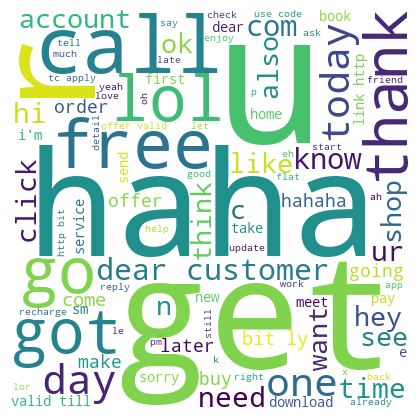


Wordcloud for Legitimate Texts:


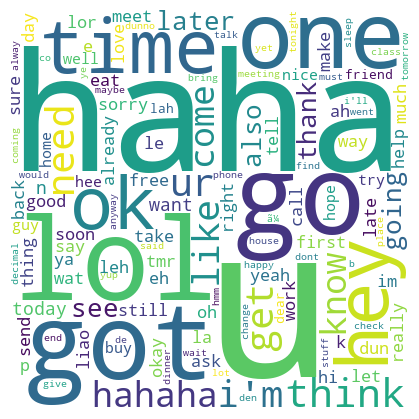


Wordcloud for Spam Texts:


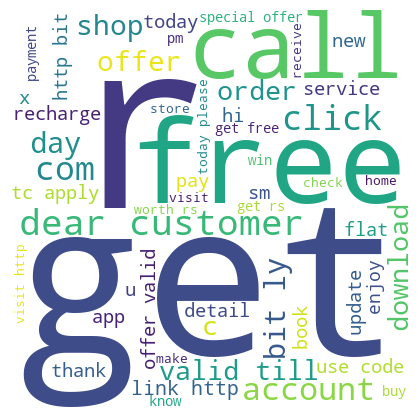

In [5]:
generate_wordclouds(X, y)

### Number of characters analysis - raw data
These histograms compare text message length based on number of characters. There is one histogram for all text messages, one for legitimate texts, and one for spam texts. Two distinct peaks are shown in the histogram for all texts, with legitimate texts generally having fewer characters and spam texts generally having more characters.

Note: X limits have been implemented for each histogram type

Number of Characters Histogram for All Texts:


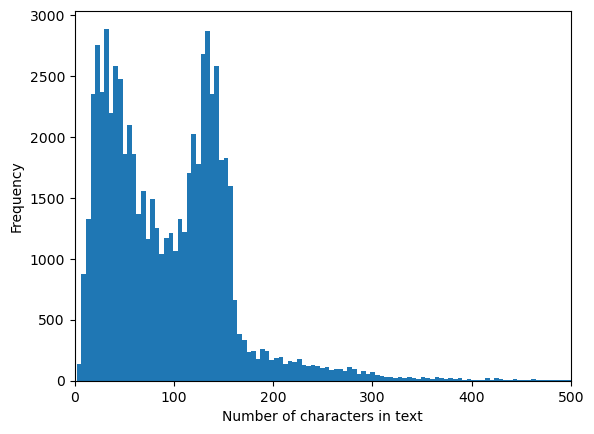


Number of Characters Histogram for Legitimate Texts:


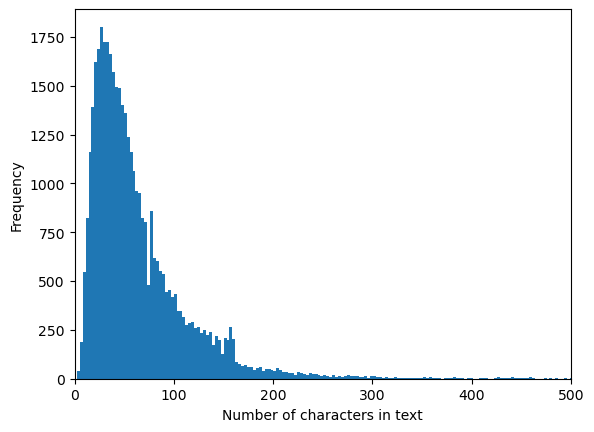


Number of Characters Histogram for Spam Texts:


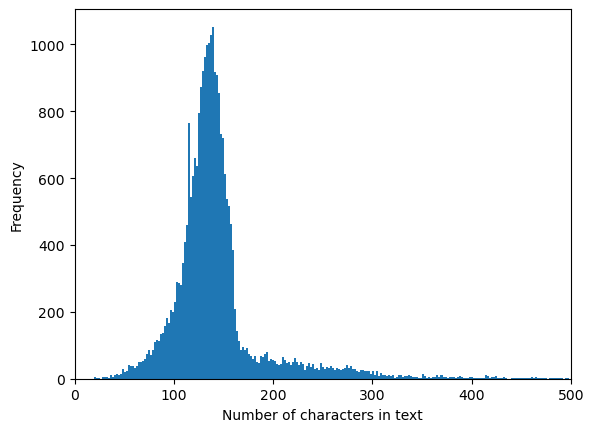

In [6]:
generate_histograms(X, y, 'Number of Characters')

### Word count analysis - raw data
These histograms compare text message length based on word count. There is one histogram for all text messages, one for legitimate texts, and one for spam texts. Similar to the number of characters histograms, two distinct peaks are shown in the histogram for all texts, with legitimate texts generally having fewer words and spam texts generally having more words.

Note: X limits have been implemented for each histogram type

Word Count Histogram for All Texts:


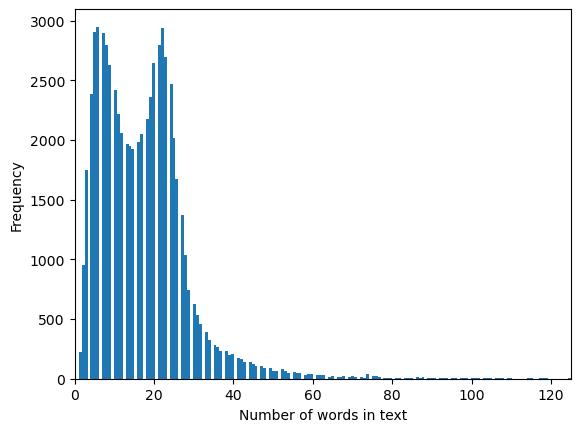


Word Count Histogram for Legitimate Texts:


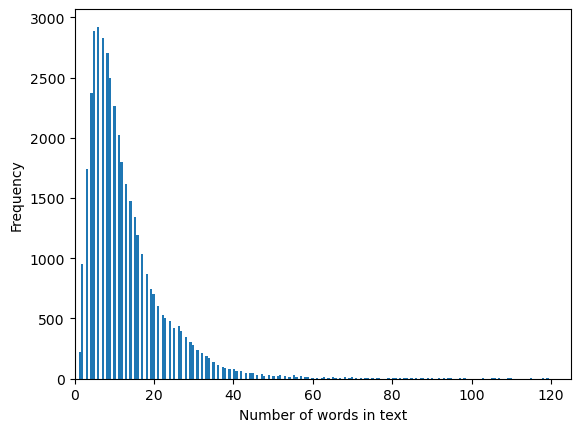


Word Count Histogram for Spam Texts:


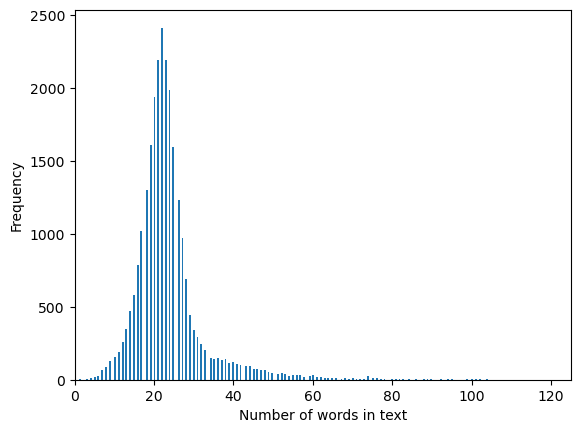

In [7]:
generate_histograms(X, y, 'Word Count')

### Average word length analysis - raw data
These histograms compare the average word length via characters, without excluding stopwords. There is one histogram for all text messages, one for legitimate texts, and one for spam texts. While the difference is not as noticable as the above histograms, there is a modest tendency for spam messages to use words with more characters.

Note: X limits have been implemented for each histogram type

Average Word Length Histogram for All Texts:


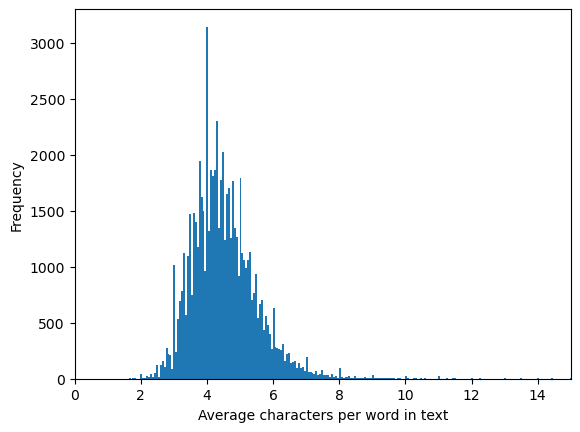


Average Word Length Histogram for Legitimate Texts:


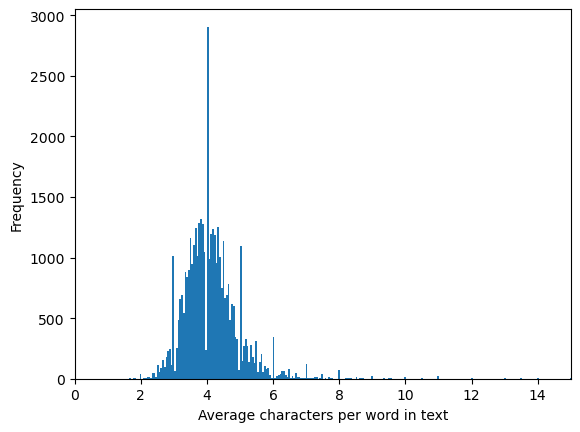


Average Word Length Histogram for Spam Texts:


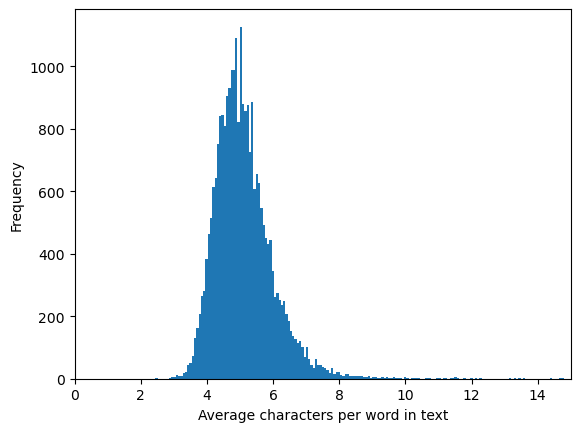

In [8]:
generate_histograms(X, y, 'Average Word Length')

## 4. Create Derived Features: Word Count and URL Presence
These derived features will be dropped in 9. Vectorization and reintroduced in 12. Research Question 3: Using Derived Features. See Section 12 for greater detail.

In [9]:
X_derived = create_derived_features(X)

********** Creating Derived Features **********

Adding column for word count.

Adding column for URL presence: 1 if URL substring found, 0 otherwise.

url_presence
0    57855
1     9131
Name: count, dtype: int64

Updated Data View:
                                                                                                      text  \
0            There be an update for your delivery CC 01728161E due 09.06.2020 Tap here http://olo.me/3i6xF   
1      watch your favorite english movies of all genre like fast  furious  the thaw stepup  in just rs ...   
2                                                                           aur what is the status for fms   
3      hi shalini sundi thank you for dialling  special offer for you is talk to stars to subscribe  di...   
4                                                                             m tryin to understand too...   
...                                                                                                    ... 

## 5. Data Preprocessing

In [10]:
X_stem, X_lem = preprocess_data(X_derived, verbose=1)


********** Preprocessing **********

Convert to string:
0    There be an update for your delivery CC 017281...
1    watch your favorite english movies of all genr...
2                       aur what is the status for fms
Name: text, dtype: object

Convert to lowercase:
0    there be an update for your delivery cc 017281...
1    watch your favorite english movies of all genr...
2                       aur what is the status for fms
Name: text, dtype: object

Remove punctuation:
0    there be an update for your delivery cc 017281...
1    watch your favorite english movies of all genr...
2                       aur what is the status for fms
Name: text, dtype: object

Tokenize:
0    [there, be, an, update, for, your, delivery, c...
1    [watch, your, favorite, english, movies, of, a...
2               [aur, what, is, the, status, for, fms]
Name: text, dtype: object

Remove stopwords:
0    [update, delivery, cc, 01728161e, due, 0906202...
1    [watch, favorite, english, movies, genre, lik

## 6. Remove Instances Where Preprocessing Removed All Text

Some texts composed of only stopwords were completely removed by preprocessing and cannot be used for model training as a result.

In [11]:
X_stem_clean, y_stem = drop_instances_with_empty_text(X_stem, y)

********** Dropping instances with empty text after preprocessing **********

No of rows (before dropping empty strings): 66986
No of columns: 4

No of rows (after dropping empty strings): 66787
No of columns: 4

Label distribution of removed instances:
label
0.0    199
Name: count, dtype: int64


In [12]:
X_lem_clean, y_lem = drop_instances_with_empty_text(X_lem, y)

********** Dropping instances with empty text after preprocessing **********

No of rows (before dropping empty strings): 66986
No of columns: 4

No of rows (after dropping empty strings): 66787
No of columns: 4

Label distribution of removed instances:
label
0.0    199
Name: count, dtype: int64


## 7. Splitting Data

#### Stemmed data

In [13]:
X_train_stem, X_val_stem, X_test_stem, y_train_stem, y_val_stem, y_test_stem = \
                                                split_data(X_stem_clean, y_stem, desired_random_state=42)

********** Splitting Data **********

Train Data: (53429, 3)
Val Data: (6679, 3)
Test Data: (6679, 3)

Class Counts(label, row): Train
label
0.0    32503
1.0    20926
Name: count, dtype: int64

Class Counts(label, row): Val
label
0.0    4063
1.0    2616
Name: count, dtype: int64

Class Counts(label, row): Test
label
0.0    4063
1.0    2616
Name: count, dtype: int64

Data View: X Train
                                                text  word_count  url_presence
0  heyhey u make urself free thursday friday odac...          21             0
1       let u chang one anyway sleep earli nite nite          10             0
2                            keep payasam rinu bring           7             0

Data View: X Val
                                                text  word_count  url_presence
0  hihi sorri wont go tmr coz sc gm last one soca...          42             0
1                                   congratul fr bob           3             0
2  exclus prolin men jogger track pant pa

#### Lemmatized data

In [14]:
X_train_lem, X_val_lem, X_test_lem, y_train_lem, y_val_lem, y_test_lem = \
                                                split_data(X_lem_clean, y_lem, desired_random_state=42)

********** Splitting Data **********

Train Data: (53429, 3)
Val Data: (6679, 3)
Test Data: (6679, 3)

Class Counts(label, row): Train
label
0.0    32503
1.0    20926
Name: count, dtype: int64

Class Counts(label, row): Val
label
0.0    4063
1.0    2616
Name: count, dtype: int64

Class Counts(label, row): Test
label
0.0    4063
1.0    2616
Name: count, dtype: int64

Data View: X Train
                                                text  word_count  url_presence
0  heyhey u make urself free thursday friday odac...          21             0
1      let u change one anyway sleep early nite nite          10             0
2                           keep payasam rinu brings           7             0

Data View: X Val
                                                text  word_count  url_presence
0  hihi sorry wont going tmr coz sc gm last one s...          42             0
1                              congratulation fr bob           3             0
2  exclusive proline men jogger track pan

## 8. Data visualization using X_train_stem data

### Wordclouds - processed data
These appear sparser with the removal of stopwords.


Wordcloud for All Texts:


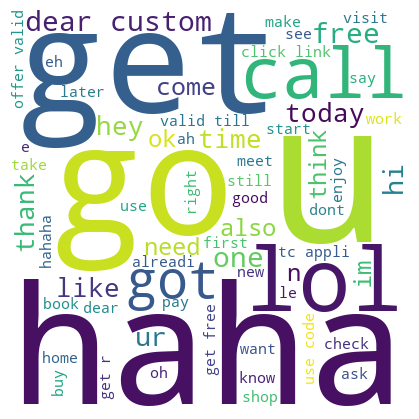


Wordcloud for Legitimate Texts:


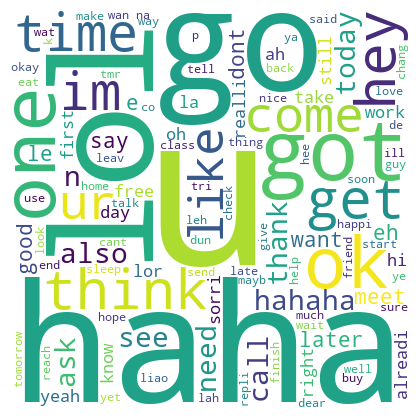


Wordcloud for Spam Texts:


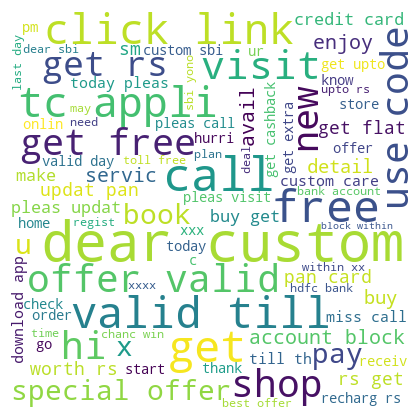

In [15]:
generate_wordclouds(X_train_stem, y_train_stem)

### Number of characters - processed data
The number of characters has generally gone down (shifted left on the x axis) through preprocessing. This is expected because stemming removes prefixes and affixes. The general trends previously seen are still present.

Note: X limits have been implemented for each histogram type

Number of Characters Histogram for All Texts:


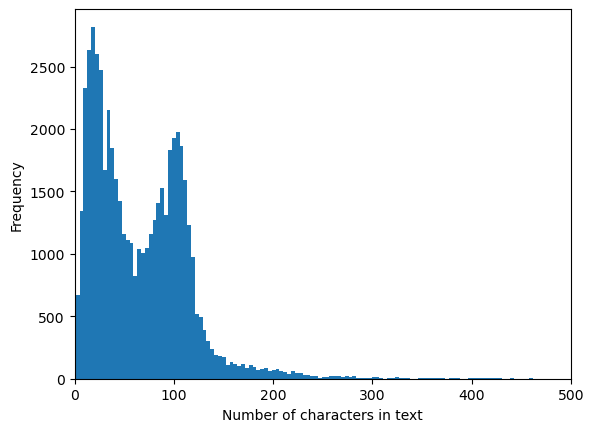


Number of Characters Histogram for Legitimate Texts:


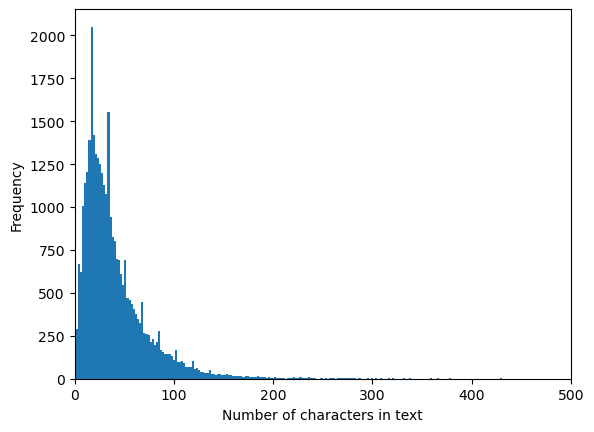


Number of Characters Histogram for Spam Texts:


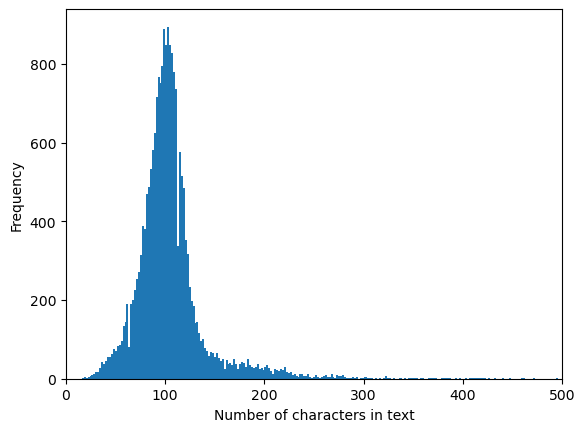

In [16]:
generate_histograms(X_train_stem, y_train_stem, 'Number of Characters')

### Word count - processed data
This data is preserved thanks to the derived feature word_count column. As such, I did not re-create the histogram with processed data

### Average word length - processed data
Similar to the number of characters, there have been slight changes in overall average word length, though the general trends noted before are still present.

Note: X limits have been implemented for each histogram type

Average Word Length Histogram for All Texts:


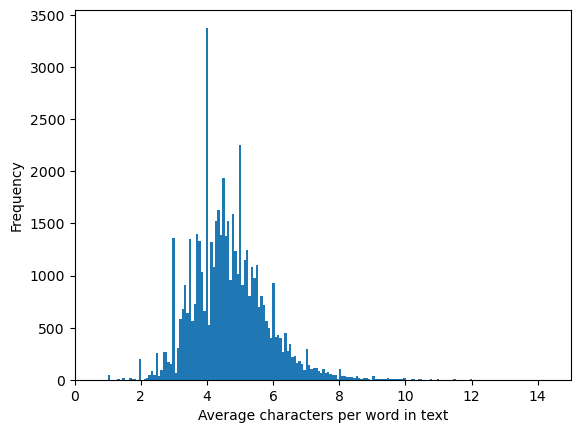


Average Word Length Histogram for Legitimate Texts:


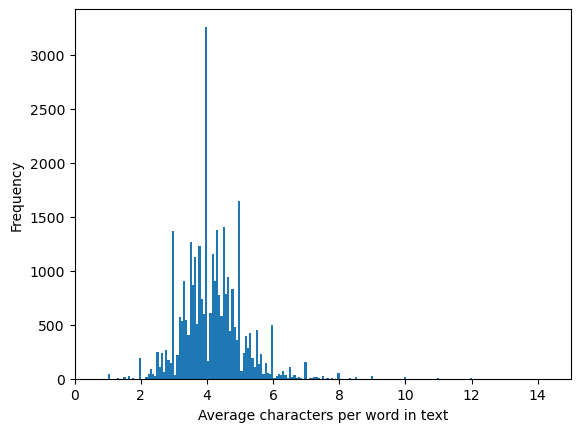


Average Word Length Histogram for Spam Texts:


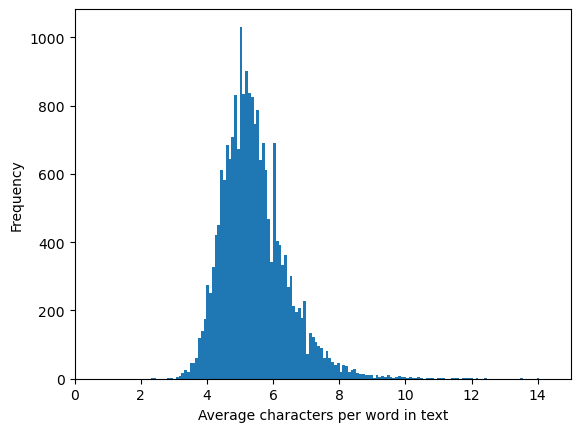

In [17]:
generate_histograms(X_train_stem, y_train_stem, 'Average Word Length')

## 9. Vectorization
Due to issues with how TF-IDF vectorizer returns data, the attributes for word_count and url_presence could not be added back into the full vectorized X_train data. More detail below in Section 12, where only Word2Vec is used to compare derived features.

### TF-IDF

#### Stemmed data

In [18]:
X_train_stem_TFIDF, X_test_stem_TFIDF, X_val_stem_TFIDF = \
                            vectorize_text_data(X_train_stem, X_test_stem, X_val_stem, method='TF-IDF', word2vec_model=0)


********** Vectorizing Data Using TF-IDF **********
Derived features are dropped during this step and will be reintroduced later.

 Data View: First Few Instances of X_train
                                                   0
0    (0, 22031)\t0.3592041103727695\n  (0, 34343)...
1    (0, 32965)\t0.26750266310788967\n  (0, 11587...
2    (0, 31430)\t0.324308455926862\n  (0, 41123)\...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53429 entries, 0 to 53428
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       53429 non-null  object
dtypes: object(1)
memory usage: 417.5+ KB
None


#### Lemmatized data

In [19]:
X_train_lem_TFIDF, X_test_lem_TFIDF, X_val_lem_TFIDF = \
                                vectorize_text_data(X_train_lem, X_test_lem, X_val_lem, method='TF-IDF', word2vec_model=0)


********** Vectorizing Data Using TF-IDF **********
Derived features are dropped during this step and will be reintroduced later.

 Data View: First Few Instances of X_train
                                                   0
0    (0, 23823)\t0.355570203689052\n  (0, 36677)\...
1    (0, 35184)\t0.26594554529073466\n  (0, 12210...
2    (0, 33561)\t0.31472718992652093\n  (0, 43863...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53429 entries, 0 to 53428
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       53429 non-null  object
dtypes: object(1)
memory usage: 417.5+ KB
None


### Word2Vec

Similar to Salman et al. (2024), whose code is referenced here: https://github.com/smspamresearch/spstudy/blob/main/Code/TCSVM_Semantic.ipynb, I am using a pre-trained version of Word2Vec; it was trained using Google News and returns 300-dimension vectors. Pre-trained gensim models can be found here: https://github.com/piskvorky/gensim-data?tab=readme-ov-file. I had some issues with exceeding the IOPub message rate, though the model should fully load given enough time, even with these warnings. I also had instances where using the Word2Vec model after loading it killed the Jupyter notebook kernel. This happened if the memory on the notebook instance was not large enough, and upgrading the notebook instance fixed the problem. The notebook instance I am using is ml.r5.xlarge (vCPU 4, Memory 32GB), with the volume size set to 100GB EBS.

In [20]:
# WARNING, THIS CELL MAY NEED TO BE RERUN
# Rerun this cell if it does not fully load the model (i.e. progress bar is not at least 98%
# before interruption because of message warning) 
# AND the cell appears to be finished running (i.e. no longer "In [*]"). 
# This should not be needed if the notebook has already been run.
word2vec = gensim_api.load('word2vec-google-news-300')

[=====---------------------------------------------] 10.9% 180.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.7% 245.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.2% 369.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 26.0% 431.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 30.1% 501.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.3% 570.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.3% 620.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.9% 1129.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.3% 1201.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.0% 1279.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================================------] 89.0% 1479.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.9% 1511.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.4% 1586.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.7% 1640.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Stemmed data

In [21]:
# This cell may take ~20 seconds to run.
X_train_stem_w2v, X_test_stem_w2v, X_val_stem_w2v = \
                    vectorize_text_data(X_train_stem, X_test_stem, X_val_stem, method='Word2Vec', word2vec_model=word2vec)


********** Vectorizing Data Using Word2Vec **********
Derived features are dropped during this step and will be reintroduced later.

 Data View: First Few Instances of X_train
        0         1         2         3         4         5         6    \
0 -0.034948 -0.003149  0.023249  0.043682 -0.010394 -0.001469 -0.010375   
1 -0.025101  0.011835  0.022956  0.076747 -0.016538 -0.012953  0.003299   
2 -0.027447  0.034664 -0.002553  0.044953 -0.015008  0.014630  0.041799   

        7         8         9    ...       290       291       292       293  \
0 -0.048959  0.032245  0.035078  ...  0.004824  0.057226 -0.053519 -0.003208   
1 -0.066018  0.032587  0.013511  ...  0.030209  0.058923 -0.041464 -0.001691   
2  0.006445 -0.018475  0.038192  ... -0.038710  0.051113 -0.008210  0.073246   

        294       295       296       297       298       299  
0 -0.018251 -0.023050 -0.042491 -0.036175  0.009451 -0.009758  
1 -0.044348 -0.020882 -0.075804 -0.035567 -0.016697  0.022203  
2 -0.0046

#### Lemmatized data

In [22]:
X_train_lem_w2v, X_test_lem_w2v, X_val_lem_w2v = \
                    vectorize_text_data(X_train_lem, X_test_lem, X_val_lem, method='Word2Vec', word2vec_model=word2vec)


********** Vectorizing Data Using Word2Vec **********
Derived features are dropped during this step and will be reintroduced later.

 Data View: First Few Instances of X_train
        0         1         2         3         4         5         6    \
0 -0.035398  0.001525  0.014116  0.040192 -0.005294  0.002979 -0.011244   
1 -0.008294  0.004685  0.017111  0.081443 -0.016963 -0.021602 -0.010864   
2 -0.006362  0.017365 -0.000856  0.038256  0.009286  0.010954  0.032643   

        7         8         9    ...       290       291       292       293  \
0 -0.052993  0.036527  0.027748  ...  0.004725  0.050792 -0.042472 -0.002905   
1 -0.062712  0.034759  0.020883  ...  0.013810  0.048441 -0.040094 -0.009368   
2 -0.009032 -0.018923  0.025628  ... -0.035354  0.027047 -0.022364  0.080531   

        294       295       296       297       298       299  
0 -0.005544 -0.023716 -0.042367 -0.046892 -0.001027  0.007283  
1 -0.050051 -0.007605 -0.061431 -0.025015 -0.002267  0.011409  
2 -0.0202

## 10. Research Questions 1 & 2: Model Training and Comparison

Each model was trained, and accuracy was compared to choose one SVM model and one RF model for finetuning when attempting to answer Research Questions 1 and 2. Due to data incompatibality when trying to add additional columns to returned TF-IDF vectors, Research Question 3 was investigated using only Word2Vec data, which is explored more in Section 12. More detail is included in the final project writeup.

In case it is helpful, Research Questions 1 and 2 are repeated below:

1. Using a larger, balanced, up-to-date dataset, can SVM and RF still achieve 99%+ accuracy in classifying SMS spam based on the text of a SMS message, similar to that described by Uddin et al. (2024)^ and Abid et al. (2022)^?
2. Between TF-IDF and Word2Vec, which feature extraction method provides the best basis for each model?

^ see final write up for further details

Models 10a (SVM) and 10g (RF) showed the highest accuracy of their model types.

### 10a. SVM with stemming and TFIDF
**NOTE:** This model has the highest accuracy among SVM models and the training data will be used for model finetuning.

In [23]:
# This took ~8 minutes to train
model_SVM_stem_TFIDF = fit_model(X_train_stem_TFIDF, y_train_stem, 'SVM', desired_random_state=42)

********** Training SVM Model **********
*** Model Training Complete ***


In [24]:
y_pred_SVM_stem_TFIDF = model_SVM_stem_TFIDF.predict(X_test_stem_TFIDF)


************** Model Evaluation for SVM_stem_TFIDF **************

Confusion Matrix:
[[4024   39]
 [  97 2519]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9765    0.9904    0.9834      4063
         1.0     0.9848    0.9629    0.9737      2616

    accuracy                         0.9796      6679
   macro avg     0.9806    0.9767    0.9785      6679
weighted avg     0.9797    0.9796    0.9796      6679



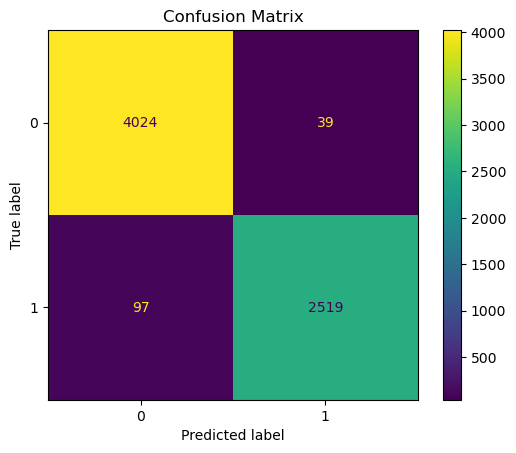

In [25]:
SVM_stem_TFIDF_eval = evaluate_model(model_name='SVM_stem_TFIDF', y_true=y_test_stem, y_pred=y_pred_SVM_stem_TFIDF)

### 10b. SVM with stemming and Word2Vec

In [26]:
# This took ~4 minutes to train
model_SVM_stem_w2v = fit_model(X_train_stem_w2v, y_train_stem, 'SVM', desired_random_state=42)

********** Training SVM Model **********
*** Model Training Complete ***


In [27]:
y_pred_SVM_stem_w2v = model_SVM_stem_w2v.predict(X_test_stem_w2v)


************** Model Evaluation for SVM_stem_W2V **************

Confusion Matrix:
[[3984   79]
 [ 125 2491]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9696    0.9806    0.9750      4063
         1.0     0.9693    0.9522    0.9607      2616

    accuracy                         0.9695      6679
   macro avg     0.9694    0.9664    0.9679      6679
weighted avg     0.9695    0.9695    0.9694      6679



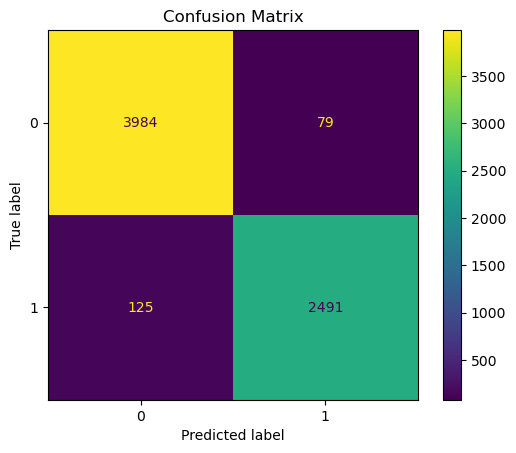

In [28]:
SVM_stem_W2V_eval = evaluate_model(model_name='SVM_stem_W2V', y_true=y_test_stem, y_pred=y_pred_SVM_stem_w2v)

### 10c. SVM with lemmatization and TFIDF

In [29]:
# This took ~7 minutes to train
model_SVM_lem_TFIDF = fit_model(X_train_lem_TFIDF, y_train_lem, 'SVM', desired_random_state=42)

********** Training SVM Model **********
*** Model Training Complete ***


In [30]:
y_pred_SVM_lem_TFIDF = model_SVM_lem_TFIDF.predict(X_test_lem_TFIDF)


************** Model Evaluation for SVM_lem_TFIDF **************

Confusion Matrix:
[[4017   46]
 [ 102 2514]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9752    0.9887    0.9819      4063
         1.0     0.9820    0.9610    0.9714      2616

    accuracy                         0.9778      6679
   macro avg     0.9786    0.9748    0.9767      6679
weighted avg     0.9779    0.9778    0.9778      6679



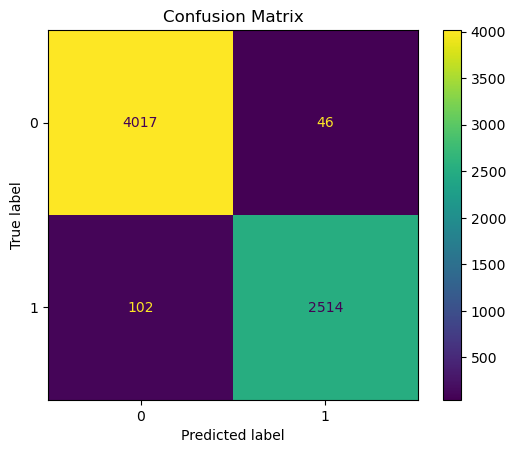

In [31]:
SVM_lem_TFIDF_eval = evaluate_model(model_name='SVM_lem_TFIDF', y_true=y_test_lem, y_pred=y_pred_SVM_lem_TFIDF)

### 10d. SVM with lemmatization and Word2Vec

In [32]:
# This took ~5 minutes to train
model_SVM_lem_w2v = fit_model(X_train_lem_w2v, y_train_lem, 'SVM', desired_random_state=42)

********** Training SVM Model **********
*** Model Training Complete ***


In [33]:
y_pred_SVM_lem_w2v = model_SVM_lem_w2v.predict(X_test_lem_w2v)


************** Model Evaluation for SVM_lem_W2V **************

Confusion Matrix:
[[3989   74]
 [ 107 2509]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9739    0.9818    0.9778      4063
         1.0     0.9714    0.9591    0.9652      2616

    accuracy                         0.9729      6679
   macro avg     0.9726    0.9704    0.9715      6679
weighted avg     0.9729    0.9729    0.9729      6679



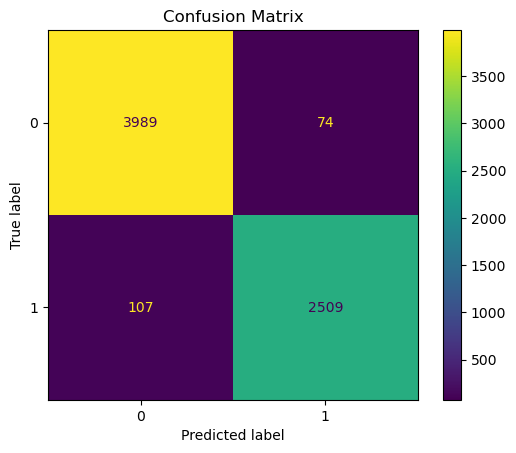

In [34]:
SVM_lem_W2V_eval = evaluate_model(model_name='SVM_lem_W2V', y_true=y_test_lem, y_pred=y_pred_SVM_lem_w2v)

### 10e. RF with stemming and TFIDF

In [35]:
# This took ~4 minutes to train
model_RF_stem_TFIDF = fit_model(X_train_stem_TFIDF, y_train_stem, 'RF', desired_random_state=42)

********** Training RF Model **********
*** Model Training Complete ***


In [36]:
y_pred_RF_stem_TFIDF = model_RF_stem_TFIDF.predict(X_test_stem_TFIDF)


************** Model Evaluation for RF_stem_TFIDF **************

Confusion Matrix:
[[4039   24]
 [ 151 2465]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9640    0.9941    0.9788      4063
         1.0     0.9904    0.9423    0.9657      2616

    accuracy                         0.9738      6679
   macro avg     0.9772    0.9682    0.9723      6679
weighted avg     0.9743    0.9738    0.9737      6679



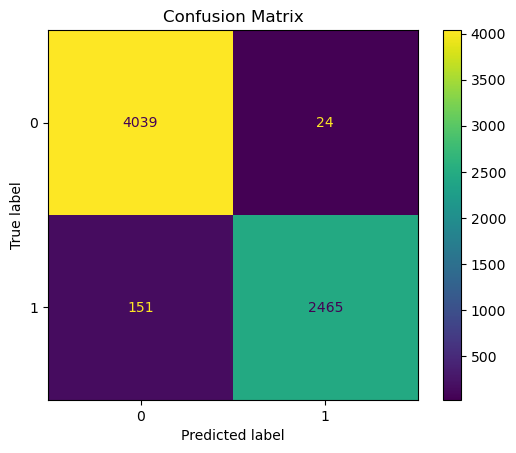

In [37]:
RF_stem_TFIDF_eval = evaluate_model(model_name='RF_stem_TFIDF', y_true=y_test_stem, y_pred=y_pred_RF_stem_TFIDF)

### 10f. RF with stemming and Word2Vec

In [38]:
# This took ~4 minutes to train
model_RF_stem_w2v = fit_model(X_train_stem_w2v, y_train_stem, 'RF', desired_random_state=42)

********** Training RF Model **********
*** Model Training Complete ***


In [39]:
y_pred_RF_stem_w2v = model_RF_stem_w2v.predict(X_test_stem_w2v)


************** Model Evaluation for RF_stem_W2V **************

Confusion Matrix:
[[3978   85]
 [ 203 2413]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9514    0.9791    0.9651      4063
         1.0     0.9660    0.9224    0.9437      2616

    accuracy                         0.9569      6679
   macro avg     0.9587    0.9507    0.9544      6679
weighted avg     0.9571    0.9569    0.9567      6679



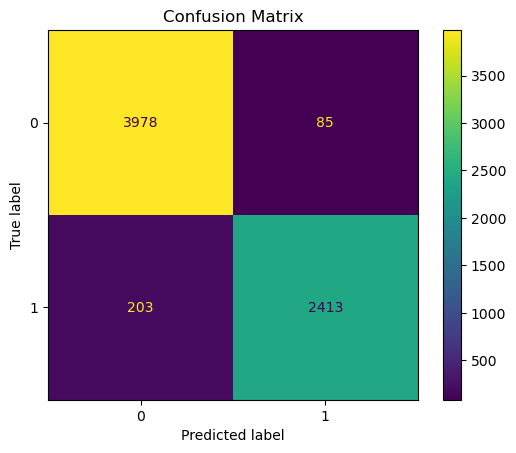

In [40]:
RF_stem_W2V_eval = evaluate_model(model_name='RF_stem_W2V', y_true=y_test_stem, y_pred=y_pred_RF_stem_w2v)

### 10g. RF with lemmatization and TFIDF
**NOTE**: This model has the highest accuracy among RF models and the training data will be used for model finetuning.

In [41]:
# This took ~6 minutes to train
model_RF_lem_TFIDF = fit_model(X_train_lem_TFIDF, y_train_lem, 'RF', desired_random_state=42)

********** Training RF Model **********
*** Model Training Complete ***


In [42]:
y_pred_RF_lem_TFIDF = model_RF_lem_TFIDF.predict(X_test_lem_TFIDF)


************** Model Evaluation for RF_lem_TFIDF **************

Confusion Matrix:
[[4040   23]
 [ 146 2470]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9651    0.9943    0.9795      4063
         1.0     0.9908    0.9442    0.9669      2616

    accuracy                         0.9747      6679
   macro avg     0.9779    0.9693    0.9732      6679
weighted avg     0.9752    0.9747    0.9746      6679



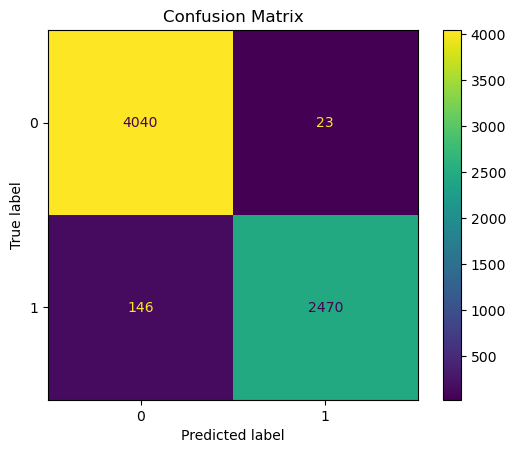

In [43]:
RF_lem_TFIDF_eval = evaluate_model(model_name='RF_lem_TFIDF', y_true=y_test_lem, y_pred=y_pred_RF_lem_TFIDF)

### 10h. RF with lemmatization and Word2Vec

In [44]:
# This took ~4 minutes to train
model_RF_lem_w2v = fit_model(X_train_lem_w2v, y_train_lem, 'RF', desired_random_state=42)

********** Training RF Model **********
*** Model Training Complete ***


In [45]:
y_pred_RF_lem_w2v = model_RF_lem_w2v.predict(X_test_lem_w2v)


************** Model Evaluation for RF_lem_W2V **************

Confusion Matrix:
[[3992   71]
 [ 190 2426]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9546    0.9825    0.9683      4063
         1.0     0.9716    0.9274    0.9490      2616

    accuracy                         0.9609      6679
   macro avg     0.9631    0.9549    0.9586      6679
weighted avg     0.9612    0.9609    0.9607      6679



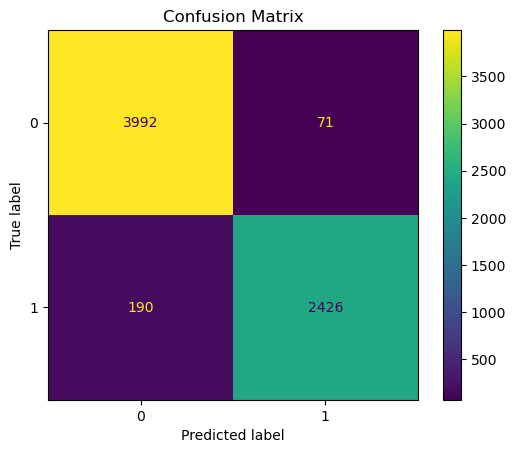

In [46]:
RF_lem_W2V_eval = evaluate_model(model_name='RF_lem_W2V', y_true=y_test_lem, y_pred=y_pred_RF_lem_w2v)

## 11. Research Questions 1 & 2: Model Finetuning for Selected Models
The training data for each finetuned model was chosen based on the accuracy presented in the previous models in Step 10. From the previous models, X_train and X_test were combined into X_train_new, and X_val was used for the final test of the model

### Optimized SVM with stemming and TFIDF

In [47]:
SVM_param_grid = {'random_state': [42]}

In [48]:
# This took ~33 minutes to run
optimized_SVM = GridSearchCV(SVC(), param_grid=SVM_param_grid, refit=True, verbose=3)
optimized_SVM.fit(X_train_stem_TFIDF, y_train_stem)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...................random_state=42;, score=0.975 total time= 4.2min
[CV 2/5] END ...................random_state=42;, score=0.979 total time= 4.2min
[CV 3/5] END ...................random_state=42;, score=0.976 total time= 4.2min
[CV 4/5] END ...................random_state=42;, score=0.976 total time= 4.2min
[CV 5/5] END ...................random_state=42;, score=0.976 total time= 4.2min


GridSearchCV(estimator=SVC(), param_grid={'random_state': [42]}, verbose=3)

In [49]:
SVM_params = optimized_SVM.get_params()
SVM_params

{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None,
 'param_grid': {'random_state': [42]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 3}

In [50]:
optimized_SVM_pred = optimized_SVM.predict(X_val_stem_TFIDF)


************** Model Evaluation for Optimized_SVM_stem_TFIDF **************

Confusion Matrix:
[[4037   26]
 [  84 2532]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9796    0.9936    0.9866      4063
         1.0     0.9898    0.9679    0.9787      2616

    accuracy                         0.9835      6679
   macro avg     0.9847    0.9807    0.9826      6679
weighted avg     0.9836    0.9835    0.9835      6679



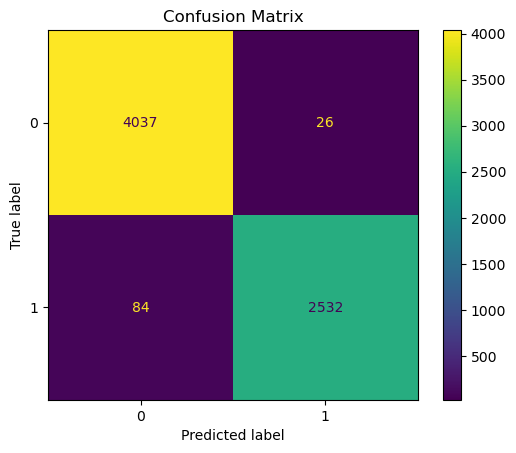

In [51]:
Optimized_SVM_stem_TFIDF_eval = evaluate_model(model_name='Optimized_SVM_stem_TFIDF', 
                                               y_true=y_val_stem,
                                               y_pred=optimized_SVM_pred)

### Optimized RF with lemmatization and TFIDF

In [52]:
RF_param_grid = {'random_state': [42]}

In [53]:
# This took ~25 minutes to run
optimized_RF = GridSearchCV(RandomForestClassifier(), param_grid=RF_param_grid, refit=True, verbose=3)
optimized_RF.fit(X_train_lem_TFIDF, y_train_lem)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...................random_state=42;, score=0.978 total time= 3.6min
[CV 2/5] END ...................random_state=42;, score=0.981 total time= 3.6min
[CV 3/5] END ...................random_state=42;, score=0.975 total time= 3.6min
[CV 4/5] END ...................random_state=42;, score=0.975 total time= 3.5min
[CV 5/5] END ...................random_state=42;, score=0.978 total time= 3.6min


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'random_state': [42]}, verbose=3)

In [54]:
RF_params = optimized_RF.get_params()
RF_params

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_jobs': None,
 'param_grid': {'random_state': [42]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 3}

In [55]:
optimized_RF_pred = optimized_RF.predict(X_val_lem_TFIDF)


************** Model Evaluation for Optimized_RF_lem_TFIDF **************

Confusion Matrix:
[[4040   23]
 [ 139 2477]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9667    0.9943    0.9803      4063
         1.0     0.9908    0.9469    0.9683      2616

    accuracy                         0.9757      6679
   macro avg     0.9788    0.9706    0.9743      6679
weighted avg     0.9762    0.9757    0.9756      6679



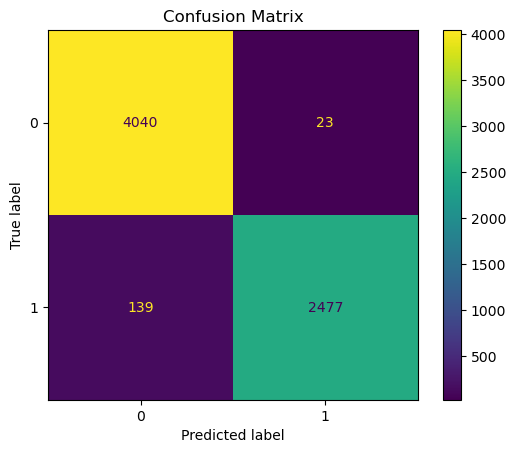

In [56]:
Optimized_RF_lem_TFIDF_eval = evaluate_model(model_name='Optimized_RF_lem_TFIDF',
                                             y_true=y_val_lem,
                                             y_pred=optimized_RF_pred)

## 12. Research Question 3: Using Derived Features
Errors consistently occurred when attempting to train a model that combined TF-IDF vectors and columns for word_count and url_presence. As such Research Question 3 was investigated using only Word2Vec data. Derived features are reintroduced below and the models that result can be compared to the models in Step 10 and 11. Additionally, since all models that used Word2Vec in Step 10 achieved better accuracy using lemmatized data, only lemmatized data is used in these sections. This is also done to save some storage space.

In case it is helpful, Research Questions 3 is repeated below:

3. Does including features related to message length and presence of a URL improve model accuracy?



### Adding derived features to Word2Vec training data

#### Lemmatized data

In [57]:
 X_train_lem_w2v_plus, X_test_lem_w2v_plus, X_val_lem_w2v_plus = \
    reintroduce_derived_features(X_train_lem, X_test_lem, X_val_lem, \
                                 X_train_lem_w2v, X_test_lem_w2v, X_val_lem_w2v)

********** Reintroducing Derived Features **********

 Data View: First Few Instances of X_train with Derived Features
        0         1         2         3         4         5         6    \
0 -0.035398  0.001525  0.014116  0.040192 -0.005294  0.002979 -0.011244   
1 -0.008294  0.004685  0.017111  0.081443 -0.016963 -0.021602 -0.010864   
2 -0.006362  0.017365 -0.000856  0.038256  0.009286  0.010954  0.032643   

        7         8         9    ...       292       293       294       295  \
0 -0.052993  0.036527  0.027748  ... -0.042472 -0.002905 -0.005544 -0.023716   
1 -0.062712  0.034759  0.020883  ... -0.040094 -0.009368 -0.050051 -0.007605   
2 -0.009032 -0.018923  0.025628  ... -0.022364  0.080531 -0.020225 -0.014840   

        296       297       298       299  300  301  
0 -0.042367 -0.046892 -0.001027  0.007283   21    0  
1 -0.061431 -0.025015 -0.002267  0.011409   10    0  
2 -0.023367  0.002224  0.060210  0.035464    7    0  

[3 rows x 302 columns]


<class 'pandas.co

## 13. Research Question 3: Training Word2Vec models with derived features

### 13a. SVM with lemmatization and Word2Vec+

In [58]:
# This took ~8 minutes to train
model_SVM_lem_w2v_plus = fit_model(X_train_lem_w2v_plus, y_train_lem, 'SVM', desired_random_state=42)

********** Training SVM Model **********
*** Model Training Complete ***


In [59]:
y_pred_SVM_lem_w2v_plus = model_SVM_lem_w2v_plus.predict(X_test_lem_w2v_plus)


************** Model Evaluation for SVM_lem_W2V_plus **************

Confusion Matrix:
[[3774  289]
 [ 150 2466]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9618    0.9289    0.9450      4063
         1.0     0.8951    0.9427    0.9183      2616

    accuracy                         0.9343      6679
   macro avg     0.9284    0.9358    0.9317      6679
weighted avg     0.9357    0.9343    0.9346      6679



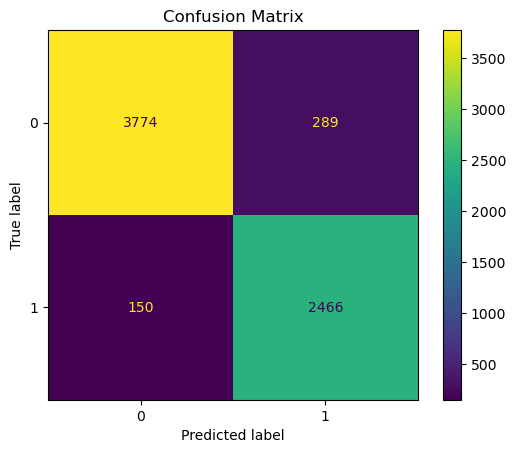

In [60]:
SVM_lem_W2V_plus_eval = evaluate_model(model_name='SVM_lem_W2V_plus', y_true=y_test_lem, y_pred=y_pred_SVM_lem_w2v_plus)

### 13b. RF with lemmatization and Word2Vec+

In [61]:
# This took ~4 minutes to train
model_RF_lem_w2v_plus = fit_model(X_train_lem_w2v_plus, y_train_lem, 'RF', desired_random_state=42)

********** Training RF Model **********
*** Model Training Complete ***


In [62]:
y_pred_RF_lem_w2v_plus = model_RF_lem_w2v_plus.predict(X_test_lem_w2v_plus)


************** Model Evaluation for RF_lem_W2V_plus **************

Confusion Matrix:
[[4003   60]
 [ 144 2472]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9653    0.9852    0.9752      4063
         1.0     0.9763    0.9450    0.9604      2616

    accuracy                         0.9695      6679
   macro avg     0.9708    0.9651    0.9678      6679
weighted avg     0.9696    0.9695    0.9694      6679



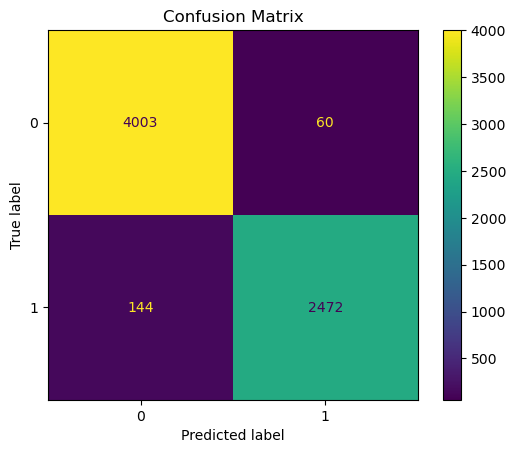

In [63]:
RF_lem_W2V_plus_eval = evaluate_model(model_name='RF_lem_W2V_plus', y_true=y_test_lem, y_pred=y_pred_RF_lem_w2v_plus)

## 14. Aggregate Model Comparison

In [64]:
list_of_eval_dictionaries = [SVM_stem_TFIDF_eval,
                             SVM_stem_W2V_eval,
                             SVM_lem_TFIDF_eval,
                             SVM_lem_W2V_eval,
                             RF_stem_TFIDF_eval,
                             RF_stem_W2V_eval,
                             RF_lem_TFIDF_eval,
                             RF_lem_W2V_eval,
                             Optimized_SVM_stem_TFIDF_eval,
                             Optimized_RF_lem_TFIDF_eval,
                             SVM_lem_W2V_plus_eval,
                             RF_lem_W2V_plus_eval]
list_of_model_labels = ['SVM_stem_TFIDF',
                        'SVM_stem_W2V',
                        'SVM_lem_TFIDF',
                        'SVM_lem_W2V',
                        'RF_stem_TFIDF',
                        'RF_stem_W2V',
                        'RF_lem_TFIDF',
                        'RF_lem_W2V',
                        'Optimized_SVM_stem_TFIDF',
                        'Optimized_RF_lem_TFIDF',
                        'SVM_lem_W2V_plus',
                        'RF_lem_W2V_plus']

In [69]:
evaluation_df = create_dataframe_of_aggregate_data(list_of_model_labels, list_of_eval_dictionaries)

In [70]:
column_names_excluding_model = ['Class 0 Precision', 'Class 1 Precision', 'Class 0 Recall', 'Class 1 Recall',
                                'Class 0 F1', 'Class 1 F1', 'Accuracy']
evaluation_df.style.background_gradient(subset=column_names_excluding_model, cmap='RdYlGn', axis=0)

,Model,Class 0 Precision,Class 1 Precision,Class 0 Recall,Class 1 Recall,Class 0 F1,Class 1 F1,Accuracy
0,SVM_stem_TFIDF,0.976462,0.984754,0.990401,0.962920,0.983382,0.973715,0.979638
1,SVM_stem_W2V,0.969579,0.969261,0.980556,0.952217,0.975037,0.960663,0.969457
2,SVM_lem_TFIDF,0.975237,0.982031,0.988678,0.961009,0.981912,0.971406,0.977841
3,SVM_lem_W2V,0.973877,0.971351,0.981787,0.959098,0.977816,0.965186,0.972900
4,RF_stem_TFIDF,0.963962,0.990358,0.994093,0.942278,0.978796,0.965720,0.973798
5,RF_stem_W2V,0.951447,0.965973,0.979079,0.922401,0.965066,0.943684,0.956880
6,RF_lem_TFIDF,0.965122,0.990774,0.994339,0.944190,0.979513,0.966921,0.974697
7,RF_lem_W2V,0.954567,0.971566,0.982525,0.927370,0.968344,0.948954,0.960922
8,Optimized_SVM_stem_TFIDF,0.979617,0.989836,0.993601,0.967890,0.986559,0.978740,0.983530
9,Optimized_RF_lem_TFIDF,0.966738,0.990800,0.994339,0.946865,0.980345,0.968335,0.975745


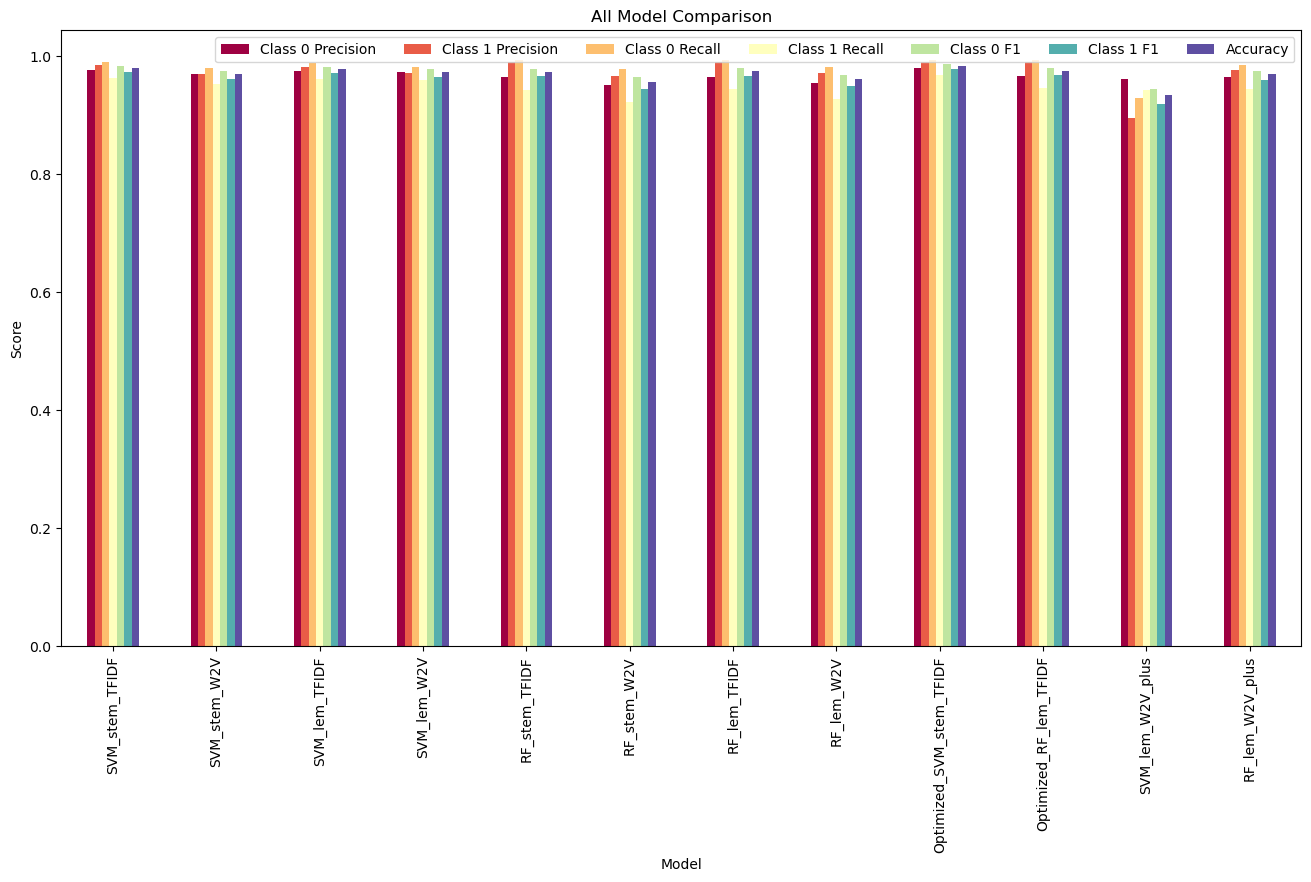

<Figure size 640x480 with 0 Axes>

In [73]:
graph_aggregate_data(evaluation_df,
                     fig_width=16,
                     fig_height=8,
                     legend_number_of_columns=7,
                     title='All Model Comparison',
                     outfile_name='')